## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2021-02-15 00:48:49--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.78.54
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.78.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.1’

train-test-data.zip 100%[===================>] 322.93M  67.3MB/s    in 4.8s    

2021-02-15 00:48:54 (67.4 MB/s) - ‘/data/train-test-data.zip.1’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [2]:
# Import all required resources 
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as I
from models import Net
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim
# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor, RandomRotate, RandomHorizontalFlip
# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
#Set Cuda Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##Initialize weights 
def init_weights(m):
    if type(m) == nn.Linear:
        I.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
        
    if isinstance(m, nn.Conv2d):
        I.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0.01)

## Instantiate the network
##Called from models.py
net = Net()
net = net.to(device)
net.apply(init_weights)
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.05)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.1)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.15)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout(p=0.2)
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (pool5): MaxPool2d(kernel_size=2, 

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(256),
                                     RandomCrop(224),
                                     RandomRotate(5),
                                     RandomHorizontalFlip(),
                                     Normalize(),
                                     ToTensor()
                                     ])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 16

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [7]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [8]:
# load test data in batches
batch_size = 16

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [9]:
# test the model on a batch of test images
if  torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    print('Training on GPU ...')
else:
    dtype = torch.FloatTensor
    print('Training on CPU ...')
    
    
def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        images = images.to(device)
        key_pts = sample['keypoints']
        key_pts = key_pts.to(device)

        # convert images to FloatTensors
        images = images.type(dtype)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

Training on GPU ...


#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [10]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [11]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='w')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='b')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

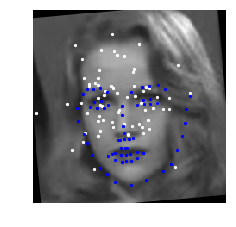

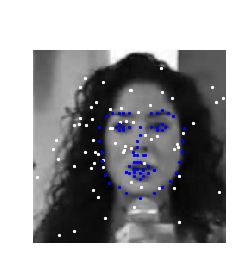

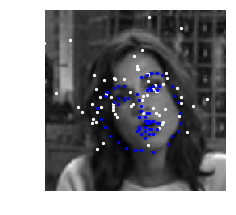

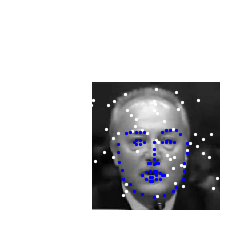

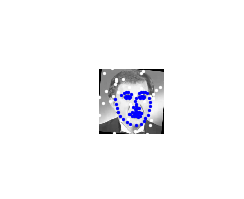

In [12]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=5):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        
        #image =  Tensor.cpu()
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
if dtype == torch.cuda.FloatTensor:
    test_images = test_images.cpu()
    test_outputs = test_outputs.cpu()
    gt_pts = gt_pts.cpu()
    
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## TODO: Define the loss and optimization
criterion = nn.SmoothL1Loss()
criterion = criterion.to(device)

optimizer = optim.Adam(net.parameters(), lr = 0.0003)

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [14]:
def train_net(n_epochs):

    loss_over_time = [] # to track the loss as the network trains
    run_loss = []
    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            images = images.to(device)
                        
            key_pts = data['keypoints']
            key_pts = key_pts.to(device)

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(dtype)
            images = images.type(dtype)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            run_loss.append(running_loss)
            if batch_i % 10 == 9:    # print every 10 batches
                avg_loss = running_loss/10
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                run_loss.append(running_loss) 
                running_loss = 0.0

    print('Finished Training')
    return [loss_over_time,run_loss]

In [15]:
# import utilities to keep workspaces alive during model training
from workspace_utils import active_session
# train your network
n_epochs = 100 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    loss = train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.43302066028118136
Epoch: 1, Batch: 20, Avg. Loss: 0.24465311765670777
Epoch: 1, Batch: 30, Avg. Loss: 0.18732040077447892
Epoch: 1, Batch: 40, Avg. Loss: 0.15457822382450104
Epoch: 1, Batch: 50, Avg. Loss: 0.1593861036002636
Epoch: 1, Batch: 60, Avg. Loss: 0.14338812306523324
Epoch: 1, Batch: 70, Avg. Loss: 0.12517382502555846
Epoch: 1, Batch: 80, Avg. Loss: 0.15435722172260286
Epoch: 1, Batch: 90, Avg. Loss: 0.1296534612774849
Epoch: 1, Batch: 100, Avg. Loss: 0.1117324523627758
Epoch: 1, Batch: 110, Avg. Loss: 0.1455540344119072
Epoch: 1, Batch: 120, Avg. Loss: 0.12612509205937386
Epoch: 1, Batch: 130, Avg. Loss: 0.14633671268820764
Epoch: 1, Batch: 140, Avg. Loss: 0.12793600410223008
Epoch: 1, Batch: 150, Avg. Loss: 0.12344655841588974
Epoch: 1, Batch: 160, Avg. Loss: 0.12315879613161088
Epoch: 1, Batch: 170, Avg. Loss: 0.10986717492341995
Epoch: 1, Batch: 180, Avg. Loss: 0.09937467724084854
Epoch: 1, Batch: 190, Avg. Loss: 0.11650249436497688
Epoch:

Epoch: 8, Batch: 100, Avg. Loss: 0.03498389758169651
Epoch: 8, Batch: 110, Avg. Loss: 0.043860236555337904
Epoch: 8, Batch: 120, Avg. Loss: 0.04145797099918127
Epoch: 8, Batch: 130, Avg. Loss: 0.05530490651726723
Epoch: 8, Batch: 140, Avg. Loss: 0.033615595661103725
Epoch: 8, Batch: 150, Avg. Loss: 0.031040087342262268
Epoch: 8, Batch: 160, Avg. Loss: 0.04813708085566759
Epoch: 8, Batch: 170, Avg. Loss: 0.041599837876856324
Epoch: 8, Batch: 180, Avg. Loss: 0.03292656764388084
Epoch: 8, Batch: 190, Avg. Loss: 0.03914442677050829
Epoch: 8, Batch: 200, Avg. Loss: 0.047548217326402666
Epoch: 8, Batch: 210, Avg. Loss: 0.043419315665960315
Epoch: 9, Batch: 10, Avg. Loss: 0.03445694018155336
Epoch: 9, Batch: 20, Avg. Loss: 0.0357770225033164
Epoch: 9, Batch: 30, Avg. Loss: 0.03340918403118849
Epoch: 9, Batch: 40, Avg. Loss: 0.039452962763607505
Epoch: 9, Batch: 50, Avg. Loss: 0.040900294296443464
Epoch: 9, Batch: 60, Avg. Loss: 0.030419000424444675
Epoch: 9, Batch: 70, Avg. Loss: 0.0350465942

Epoch: 15, Batch: 160, Avg. Loss: 0.022249876894056796
Epoch: 15, Batch: 170, Avg. Loss: 0.02201088722795248
Epoch: 15, Batch: 180, Avg. Loss: 0.02208223147317767
Epoch: 15, Batch: 190, Avg. Loss: 0.02463191542774439
Epoch: 15, Batch: 200, Avg. Loss: 0.03505454370751977
Epoch: 15, Batch: 210, Avg. Loss: 0.02651333939284086
Epoch: 16, Batch: 10, Avg. Loss: 0.028418210335075855
Epoch: 16, Batch: 20, Avg. Loss: 0.018638353049755096
Epoch: 16, Batch: 30, Avg. Loss: 0.022581019811332224
Epoch: 16, Batch: 40, Avg. Loss: 0.027328677475452423
Epoch: 16, Batch: 50, Avg. Loss: 0.026082108076661826
Epoch: 16, Batch: 60, Avg. Loss: 0.021680126991122962
Epoch: 16, Batch: 70, Avg. Loss: 0.02440192922949791
Epoch: 16, Batch: 80, Avg. Loss: 0.022043863963335752
Epoch: 16, Batch: 90, Avg. Loss: 0.03201197935268283
Epoch: 16, Batch: 100, Avg. Loss: 0.02134784385561943
Epoch: 16, Batch: 110, Avg. Loss: 0.02842007949948311
Epoch: 16, Batch: 120, Avg. Loss: 0.02149066012352705
Epoch: 16, Batch: 130, Avg. L

Epoch: 22, Batch: 210, Avg. Loss: 0.01518325824290514
Epoch: 23, Batch: 10, Avg. Loss: 0.016320483293384314
Epoch: 23, Batch: 20, Avg. Loss: 0.020769159961491823
Epoch: 23, Batch: 30, Avg. Loss: 0.019646196719259025
Epoch: 23, Batch: 40, Avg. Loss: 0.015817364584654568
Epoch: 23, Batch: 50, Avg. Loss: 0.020826663915067913
Epoch: 23, Batch: 60, Avg. Loss: 0.016491163242608308
Epoch: 23, Batch: 70, Avg. Loss: 0.01413949579000473
Epoch: 23, Batch: 80, Avg. Loss: 0.01431001527234912
Epoch: 23, Batch: 90, Avg. Loss: 0.019008626602590083
Epoch: 23, Batch: 100, Avg. Loss: 0.02140432959422469
Epoch: 23, Batch: 110, Avg. Loss: 0.015242534969002009
Epoch: 23, Batch: 120, Avg. Loss: 0.015363666694611311
Epoch: 23, Batch: 130, Avg. Loss: 0.01544436365365982
Epoch: 23, Batch: 140, Avg. Loss: 0.017015986144542694
Epoch: 23, Batch: 150, Avg. Loss: 0.023011138010770083
Epoch: 23, Batch: 160, Avg. Loss: 0.015616539493203163
Epoch: 23, Batch: 170, Avg. Loss: 0.013970333430916072
Epoch: 23, Batch: 180, A

Epoch: 30, Batch: 40, Avg. Loss: 0.013171317242085933
Epoch: 30, Batch: 50, Avg. Loss: 0.018295569531619548
Epoch: 30, Batch: 60, Avg. Loss: 0.012983006332069636
Epoch: 30, Batch: 70, Avg. Loss: 0.014866499602794648
Epoch: 30, Batch: 80, Avg. Loss: 0.01541100824251771
Epoch: 30, Batch: 90, Avg. Loss: 0.014718692749738693
Epoch: 30, Batch: 100, Avg. Loss: 0.026638259645551443
Epoch: 30, Batch: 110, Avg. Loss: 0.01347624696791172
Epoch: 30, Batch: 120, Avg. Loss: 0.01216140454635024
Epoch: 30, Batch: 130, Avg. Loss: 0.02040602285414934
Epoch: 30, Batch: 140, Avg. Loss: 0.02220452670007944
Epoch: 30, Batch: 150, Avg. Loss: 0.019527524523437024
Epoch: 30, Batch: 160, Avg. Loss: 0.013607235439121724
Epoch: 30, Batch: 170, Avg. Loss: 0.014885441027581691
Epoch: 30, Batch: 180, Avg. Loss: 0.013900431431829929
Epoch: 30, Batch: 190, Avg. Loss: 0.016559449303895236
Epoch: 30, Batch: 200, Avg. Loss: 0.013524418231099844
Epoch: 30, Batch: 210, Avg. Loss: 0.014075082261115313
Epoch: 31, Batch: 10,

Epoch: 37, Batch: 80, Avg. Loss: 0.011855288501828909
Epoch: 37, Batch: 90, Avg. Loss: 0.012191143818199635
Epoch: 37, Batch: 100, Avg. Loss: 0.012093134690076113
Epoch: 37, Batch: 110, Avg. Loss: 0.012404724024236202
Epoch: 37, Batch: 120, Avg. Loss: 0.014294979628175497
Epoch: 37, Batch: 130, Avg. Loss: 0.012277018511667848
Epoch: 37, Batch: 140, Avg. Loss: 0.012187221739441156
Epoch: 37, Batch: 150, Avg. Loss: 0.012086635455489159
Epoch: 37, Batch: 160, Avg. Loss: 0.013767760433256625
Epoch: 37, Batch: 170, Avg. Loss: 0.013187434431165457
Epoch: 37, Batch: 180, Avg. Loss: 0.01405860185623169
Epoch: 37, Batch: 190, Avg. Loss: 0.01098473658785224
Epoch: 37, Batch: 200, Avg. Loss: 0.014739036839455367
Epoch: 37, Batch: 210, Avg. Loss: 0.01182219097390771
Epoch: 38, Batch: 10, Avg. Loss: 0.013757491577416658
Epoch: 38, Batch: 20, Avg. Loss: 0.01294642873108387
Epoch: 38, Batch: 30, Avg. Loss: 0.02118004634976387
Epoch: 38, Batch: 40, Avg. Loss: 0.010892617888748646
Epoch: 38, Batch: 50,

Epoch: 44, Batch: 120, Avg. Loss: 0.010862955078482627
Epoch: 44, Batch: 130, Avg. Loss: 0.014406121429055929
Epoch: 44, Batch: 140, Avg. Loss: 0.02476099357008934
Epoch: 44, Batch: 150, Avg. Loss: 0.011372346011921764
Epoch: 44, Batch: 160, Avg. Loss: 0.012372234649956227
Epoch: 44, Batch: 170, Avg. Loss: 0.011686613690108061
Epoch: 44, Batch: 180, Avg. Loss: 0.010652547981590033
Epoch: 44, Batch: 190, Avg. Loss: 0.022956849075853825
Epoch: 44, Batch: 200, Avg. Loss: 0.02679700804874301
Epoch: 44, Batch: 210, Avg. Loss: 0.013083903025835753
Epoch: 45, Batch: 10, Avg. Loss: 0.013801713287830353
Epoch: 45, Batch: 20, Avg. Loss: 0.01213136427104473
Epoch: 45, Batch: 30, Avg. Loss: 0.010883672256022691
Epoch: 45, Batch: 40, Avg. Loss: 0.009919673949480057
Epoch: 45, Batch: 50, Avg. Loss: 0.013330266252160073
Epoch: 45, Batch: 60, Avg. Loss: 0.010202105855569243
Epoch: 45, Batch: 70, Avg. Loss: 0.016206473764032125
Epoch: 45, Batch: 80, Avg. Loss: 0.018390131182968616
Epoch: 45, Batch: 90,

Epoch: 51, Batch: 160, Avg. Loss: 0.01380307418294251
Epoch: 51, Batch: 170, Avg. Loss: 0.009382199263200164
Epoch: 51, Batch: 180, Avg. Loss: 0.013050436228513717
Epoch: 51, Batch: 190, Avg. Loss: 0.01232548924162984
Epoch: 51, Batch: 200, Avg. Loss: 0.009925835626199841
Epoch: 51, Batch: 210, Avg. Loss: 0.010073032742366195
Epoch: 52, Batch: 10, Avg. Loss: 0.010613756719976664
Epoch: 52, Batch: 20, Avg. Loss: 0.011497395345941186
Epoch: 52, Batch: 30, Avg. Loss: 0.010140385851264
Epoch: 52, Batch: 40, Avg. Loss: 0.010140819894149899
Epoch: 52, Batch: 50, Avg. Loss: 0.009154056059196591
Epoch: 52, Batch: 60, Avg. Loss: 0.01094295154325664
Epoch: 52, Batch: 70, Avg. Loss: 0.011126532778143882
Epoch: 52, Batch: 80, Avg. Loss: 0.009900922048836946
Epoch: 52, Batch: 90, Avg. Loss: 0.010699330177158118
Epoch: 52, Batch: 100, Avg. Loss: 0.009301225561648608
Epoch: 52, Batch: 110, Avg. Loss: 0.012364041619002819
Epoch: 52, Batch: 120, Avg. Loss: 0.00979194901883602
Epoch: 52, Batch: 130, Avg

Epoch: 58, Batch: 200, Avg. Loss: 0.009932597912847996
Epoch: 58, Batch: 210, Avg. Loss: 0.011496008513495326
Epoch: 59, Batch: 10, Avg. Loss: 0.009185482515022159
Epoch: 59, Batch: 20, Avg. Loss: 0.009747278923168779
Epoch: 59, Batch: 30, Avg. Loss: 0.010171202989295126
Epoch: 59, Batch: 40, Avg. Loss: 0.01589391250163317
Epoch: 59, Batch: 50, Avg. Loss: 0.01521507822908461
Epoch: 59, Batch: 60, Avg. Loss: 0.05242173196747899
Epoch: 59, Batch: 70, Avg. Loss: 0.010286981239914894
Epoch: 59, Batch: 80, Avg. Loss: 0.011219038674607874
Epoch: 59, Batch: 90, Avg. Loss: 0.009739187965169548
Epoch: 59, Batch: 100, Avg. Loss: 0.012795446533709764
Epoch: 59, Batch: 110, Avg. Loss: 0.01159375705756247
Epoch: 59, Batch: 120, Avg. Loss: 0.019360304903239013
Epoch: 59, Batch: 130, Avg. Loss: 0.010852020839229226
Epoch: 59, Batch: 140, Avg. Loss: 0.010664479807019234
Epoch: 59, Batch: 150, Avg. Loss: 0.009795705601572991
Epoch: 59, Batch: 160, Avg. Loss: 0.010257303062826396
Epoch: 59, Batch: 170, 

Epoch: 66, Batch: 30, Avg. Loss: 0.009161979053169489
Epoch: 66, Batch: 40, Avg. Loss: 0.011672281380742788
Epoch: 66, Batch: 50, Avg. Loss: 0.00994675736874342
Epoch: 66, Batch: 60, Avg. Loss: 0.00885125077329576
Epoch: 66, Batch: 70, Avg. Loss: 0.009055380057543517
Epoch: 66, Batch: 80, Avg. Loss: 0.00983138200826943
Epoch: 66, Batch: 90, Avg. Loss: 0.009877273393794895
Epoch: 66, Batch: 100, Avg. Loss: 0.01071688076481223
Epoch: 66, Batch: 110, Avg. Loss: 0.009608503058552742
Epoch: 66, Batch: 120, Avg. Loss: 0.01131618614308536
Epoch: 66, Batch: 130, Avg. Loss: 0.009158852277323604
Epoch: 66, Batch: 140, Avg. Loss: 0.013623276539146901
Epoch: 66, Batch: 150, Avg. Loss: 0.009606089955195785
Epoch: 66, Batch: 160, Avg. Loss: 0.008912497106939555
Epoch: 66, Batch: 170, Avg. Loss: 0.009547744132578372
Epoch: 66, Batch: 180, Avg. Loss: 0.009107937011867762
Epoch: 66, Batch: 190, Avg. Loss: 0.014926222246140241
Epoch: 66, Batch: 200, Avg. Loss: 0.010460497858002783
Epoch: 66, Batch: 210,

Epoch: 73, Batch: 70, Avg. Loss: 0.00836354112252593
Epoch: 73, Batch: 80, Avg. Loss: 0.008915166230872273
Epoch: 73, Batch: 90, Avg. Loss: 0.009825222520157694
Epoch: 73, Batch: 100, Avg. Loss: 0.011655860533937811
Epoch: 73, Batch: 110, Avg. Loss: 0.01070254212245345
Epoch: 73, Batch: 120, Avg. Loss: 0.013331182254478335
Epoch: 73, Batch: 130, Avg. Loss: 0.013050894998013974
Epoch: 73, Batch: 140, Avg. Loss: 0.01021893839351833
Epoch: 73, Batch: 150, Avg. Loss: 0.009361161896958948
Epoch: 73, Batch: 160, Avg. Loss: 0.00926327370107174
Epoch: 73, Batch: 170, Avg. Loss: 0.00857050190679729
Epoch: 73, Batch: 180, Avg. Loss: 0.015837697451934217
Epoch: 73, Batch: 190, Avg. Loss: 0.020002051955088973
Epoch: 73, Batch: 200, Avg. Loss: 0.010349876713007689
Epoch: 73, Batch: 210, Avg. Loss: 0.008520170534029602
Epoch: 74, Batch: 10, Avg. Loss: 0.010762670822441579
Epoch: 74, Batch: 20, Avg. Loss: 0.01157395914196968
Epoch: 74, Batch: 30, Avg. Loss: 0.009644744824618101
Epoch: 74, Batch: 40, 

Epoch: 80, Batch: 110, Avg. Loss: 0.02550702136941254
Epoch: 80, Batch: 120, Avg. Loss: 0.009545427560806275
Epoch: 80, Batch: 130, Avg. Loss: 0.010038349963724612
Epoch: 80, Batch: 140, Avg. Loss: 0.014396647131070495
Epoch: 80, Batch: 150, Avg. Loss: 0.009537422610446811
Epoch: 80, Batch: 160, Avg. Loss: 0.008916016668081284
Epoch: 80, Batch: 170, Avg. Loss: 0.008192116254940629
Epoch: 80, Batch: 180, Avg. Loss: 0.017486281832680105
Epoch: 80, Batch: 190, Avg. Loss: 0.009775889758020639
Epoch: 80, Batch: 200, Avg. Loss: 0.009090863587334751
Epoch: 80, Batch: 210, Avg. Loss: 0.008465950097888707
Epoch: 81, Batch: 10, Avg. Loss: 0.00811482071876526
Epoch: 81, Batch: 20, Avg. Loss: 0.01069163903594017
Epoch: 81, Batch: 30, Avg. Loss: 0.01289073433727026
Epoch: 81, Batch: 40, Avg. Loss: 0.0103001918643713
Epoch: 81, Batch: 50, Avg. Loss: 0.010626839660108089
Epoch: 81, Batch: 60, Avg. Loss: 0.008819166850298644
Epoch: 81, Batch: 70, Avg. Loss: 0.008862247178331017
Epoch: 81, Batch: 80, A

Epoch: 87, Batch: 150, Avg. Loss: 0.009557674918323756
Epoch: 87, Batch: 160, Avg. Loss: 0.008738786308094859
Epoch: 87, Batch: 170, Avg. Loss: 0.011059436248615384
Epoch: 87, Batch: 180, Avg. Loss: 0.01148998448625207
Epoch: 87, Batch: 190, Avg. Loss: 0.011022916063666344
Epoch: 87, Batch: 200, Avg. Loss: 0.008616623934358358
Epoch: 87, Batch: 210, Avg. Loss: 0.008931126957759262
Epoch: 88, Batch: 10, Avg. Loss: 0.013200812553986908
Epoch: 88, Batch: 20, Avg. Loss: 0.007395783392712474
Epoch: 88, Batch: 30, Avg. Loss: 0.017538159666582943
Epoch: 88, Batch: 40, Avg. Loss: 0.010248570656403898
Epoch: 88, Batch: 50, Avg. Loss: 0.015856847539544104
Epoch: 88, Batch: 60, Avg. Loss: 0.018568087881430984
Epoch: 88, Batch: 70, Avg. Loss: 0.009465541411191224
Epoch: 88, Batch: 80, Avg. Loss: 0.012520458176732063
Epoch: 88, Batch: 90, Avg. Loss: 0.008465857803821563
Epoch: 88, Batch: 100, Avg. Loss: 0.008704407652840019
Epoch: 88, Batch: 110, Avg. Loss: 0.009152689715847373
Epoch: 88, Batch: 12

Epoch: 94, Batch: 190, Avg. Loss: 0.009050238551571966
Epoch: 94, Batch: 200, Avg. Loss: 0.00814358820207417
Epoch: 94, Batch: 210, Avg. Loss: 0.006252333847805857
Epoch: 95, Batch: 10, Avg. Loss: 0.009992464445531368
Epoch: 95, Batch: 20, Avg. Loss: 0.008022319059818983
Epoch: 95, Batch: 30, Avg. Loss: 0.009363460028544069
Epoch: 95, Batch: 40, Avg. Loss: 0.008548356546089052
Epoch: 95, Batch: 50, Avg. Loss: 0.01159145007841289
Epoch: 95, Batch: 60, Avg. Loss: 0.011064284946769476
Epoch: 95, Batch: 70, Avg. Loss: 0.012899154191836714
Epoch: 95, Batch: 80, Avg. Loss: 0.01691432362422347
Epoch: 95, Batch: 90, Avg. Loss: 0.011214447068050503
Epoch: 95, Batch: 100, Avg. Loss: 0.00802604709751904
Epoch: 95, Batch: 110, Avg. Loss: 0.0076593008358031515
Epoch: 95, Batch: 120, Avg. Loss: 0.007795437099412083
Epoch: 95, Batch: 130, Avg. Loss: 0.01052139843814075
Epoch: 95, Batch: 140, Avg. Loss: 0.008500026538968086
Epoch: 95, Batch: 150, Avg. Loss: 0.00893266750499606
Epoch: 95, Batch: 160, A

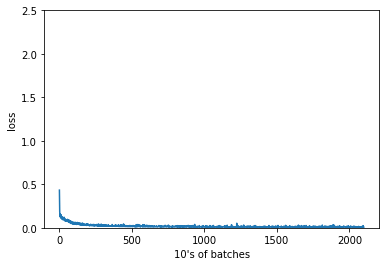

In [16]:
# visualize the loss as the network trained
loss_over_time = loss[0]
plt.plot(loss_over_time)
plt.xlabel('10\'s of batches')
plt.ylabel('loss')
plt.ylim(0, 2.5) # consistent scale
plt.show()

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [17]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


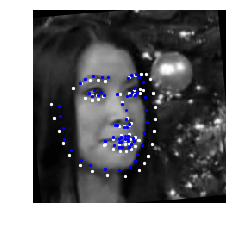

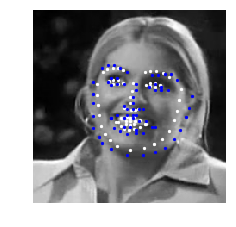

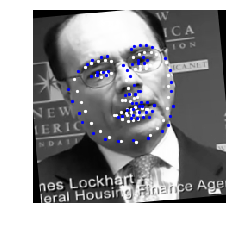

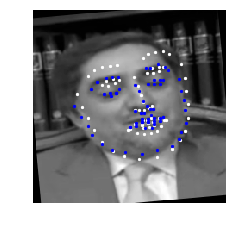

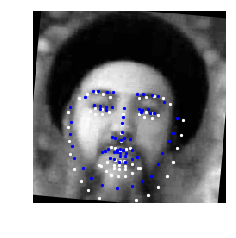

In [18]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:
if dtype == torch.cuda.FloatTensor:
    test_images = test_images.cpu()
    test_outputs = test_outputs.cpu()
    gt_pts = gt_pts.cpu()
    

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [19]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'final-model.pt'


if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'

checkpoint = torch.load(pathname, map_location=map_location)
# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


I tried out both SmoothL1Loss and MSELoss as loss functions for my neural network. These were obvious choices for a regression problem like facial keypoint detection, which attempts to estimate the approximate position of the facial landmarks. I had much better results with the **SmoothL1Loss** as a loss function and this is what I adopted for my final model. <br>

For the optimizer, I tried out both the Adam and SGD optimizers. Both of these are also suitable optimizers for the given regression task. The **Adam optimiser**, with its ability to converge to the minima quickly and efficiently, gave me better results and was the chosen optimizer for the project.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

<div style="text-align: justify"> I started out with a 2 layer convolution network which fed 2 fully connected layers. I however couldn't get this network to learn from the data as the loss was not reducing even with large training efforts. I then built on this network by adding more convolutation layers and dense layers to see how each additions affected the performace of my network </div><br>

<div style="text-align: justify"> With much experimenting, I ended up with a 5 layer convolutional network and 3 fully conneted networks. These were some of the modifications I made in the course of building the network.  </div><br>

<div style="text-align: justify"> i. I added a <b>max pooling layer</b> after each convolutional network. This was necessary to prevent the network from overfitting.  The max pooling layers help to down-sample the feature maps of each convolutional layer by summarizing the features in the feature map, thus reducing the computation cost of each pass and providing basic translation invariance to the internal representation </div><br>

<div style="text-align: justify"> ii. I also added <b>dropout layers</b> after each convolutinal network. This is also a regularization technique to prevent the network overfitting </div><br>

<div style="text-align: justify"> iii. I also applied <b>batch normalisation</b> after every 2 conv layers. Batch normalization accelerates training and provides some regularization, reducing generalization error. </div><br>

<div style="text-align: justify"> Beacuse of the size of the dataset, I applied data augmentation on the training data. This brings in a lot of variety into the training data and help reduce overfitting. I applied the Rescale, RandomCrop, Normalize, ToTensor transforms to both the training and test data sets and some more randomness in the dataset, added two custom data transforms RandomHorizontalFlip and RandomRotate. These transforms give the network the impression of additional images as each transformed image is seen uniquely. </div><br>


<div style="text-align: justify"> I also initialized the weights of my network using the  Xavier initialization. This  prevents layer activation outputs from exploding or vanishing during the course of a forward pass through the deep neural network  </div><br>

At the end, I had a deep convolutional network which able to learn the requisite features from the training dataset and implement same on the test dataset accurately.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

The batch size was basically a function of how much the Udacity workspaces was able to handle. I wasn't able to use a batch size greater than 16 without having the system crash. <br>

The number of epochs was a function of how much the network was still learning. I was able to get the best results, within the available resources at 100 epochs. 

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.03910156  0.10422897  0.06247484  0.01577633  0.07483205]
 [ 0.08635723  0.06072598  0.0350899   0.03584373  0.01387202]
 [-0.0204469  -0.05580647 -0.07598335  0.05190768 -0.03831286]
 [-0.08102489 -0.0243715   0.05583188 -0.05296035 -0.10573701]
 [ 0.01784649 -0.02790982 -0.09592587 -0.11859883 -0.00292809]]
(5, 5)


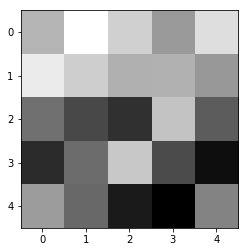

In [20]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
net.cpu()

weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

Text(0.5,1,'Original image')

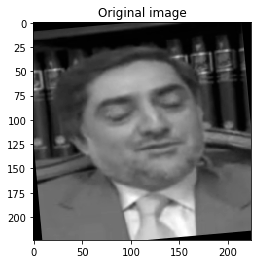

In [21]:
##TODO: load in and display any image from the transformed test dataset
image = test_images[3].data
image = image.cpu().numpy()
image = np.transpose(image, (1, 2, 0))
###SHOW IMAGE
plt.imshow(image[..., 0], cmap="gray")
plt.title("Original image")

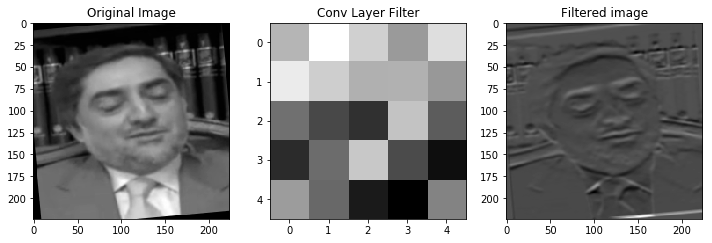

In [22]:
## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
import cv2
filters_index = 0

# Get the filters from all 5 conv layers
weights = net.conv1.weight.data.numpy()

# Store the first filter from the filters
f1 = weights[filters_index][0]

# Apply each filter
filtered_image = cv2.filter2D(image, -1, f1)

# Reshape image to show
image = image.reshape((image.shape[0],image.shape[1]))

# Plot the images
f, axes = plt.subplots(ncols=3, nrows=1, figsize=(10, 20))
axes[0].imshow(image, cmap='gray')
axes[1].imshow(f1, cmap='gray')
axes[2].imshow(filtered_image, cmap='gray')

axes[0].set_title('Original Image')
axes[1].set_title('Conv Layer Filter')
axes[2].set_title('Filtered image')

plt.tight_layout();


### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


The filter seems to highlight edges in the image.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!